In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import json
import math
from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats
from scipy.stats import gaussian_kde

from scipy.spatial import ConvexHull, convex_hull_plot_2d

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

from scipy.signal import argrelextrema,argrelmax

from itertools import chain

In [2]:
from scipy.spatial import Delaunay
import numpy as np

# https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points

#  matlab boundary - https://stackoverflow.com/questions/31836709/what-algorithm-does-matlabs-boundary-function-use

# https://www.mathworks.com/help/matlab/ref/boundary.html

#  javascript implementation of hull - https://github.com/AndriiHeonia/hull

# alpha shape https://en.wikipedia.org/wiki/Alpha_shape
# https://doc.cgal.org/latest/Alpha_shapes_2/index.html

def alpha_shape(points, alpha, only_outer=False):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [3]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

210.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


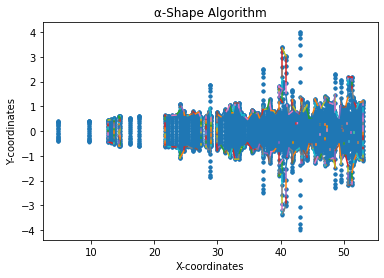

211.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


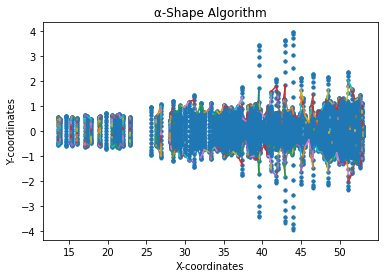

212.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


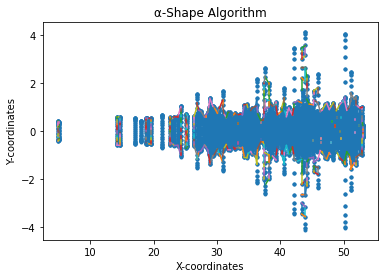

213.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


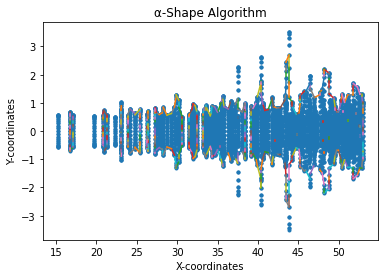

214.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


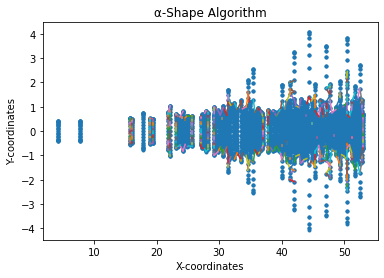

215.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


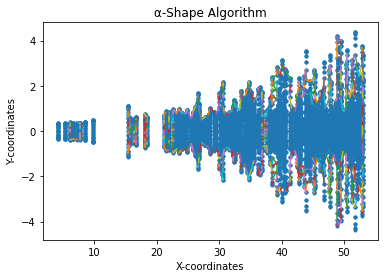

216.csv


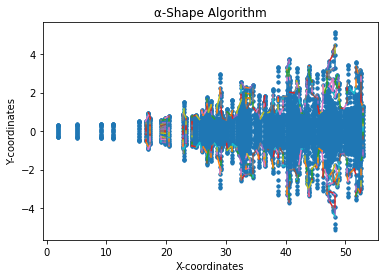

217.csv


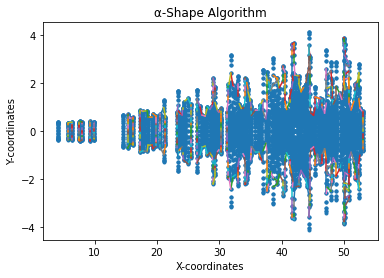

218.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


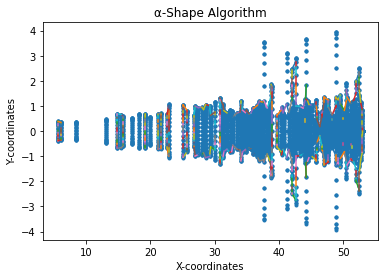

219.csv


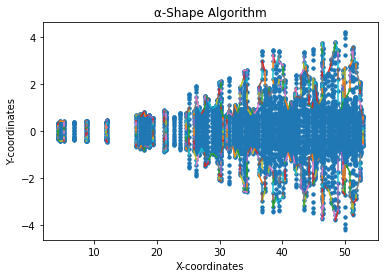

In [4]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width', 'slope']

fileName = []
area = []
length = []
height = []
width = []
slope = []

alphaValue = 0.35
ordBounLen = 5
maximaDistance = 0.4
        
# folders = ['contrails1', 'contrails2', 'contrails3']
folders = ['newData']
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
#     onlyfiles = ['0.2.csv']
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        print(file)
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))

        points = np.vstack([x[inside], y[inside]]).T

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=alphaValue, only_outer=True)
        
        # Plotting the output
        plt.figure()
        plt.title('α-Shape Algorithm')
        plt.xlabel('X-coordinates')
        plt.ylabel('Y-coordinates')
        plt.plot(points[:, 0], points[:, 1], '.')
#         plt.ylim([-1, 1])
        for i, j in edges:
        #     print(i, j, points[[i, j], 0], points[[i, j], 1])

            plt.plot(points[[i, j], 0], points[[i, j], 1])

        # Save figure
#         plt.savefig('scatter_line.jpg', dpi=300, transparent=False, bbox_inches='tight')

        plt.show()
        
        

 

211.csv


<ipython-input-2-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


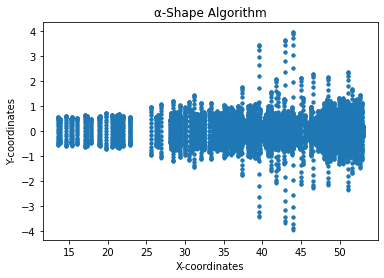

In [4]:
fileName = []
area = []
length = []
height = []
width = []
slope = []

alphaValue = 0.35
ordBounLen = 5
maximaDistance = 0.4

# onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
folder = 'newData'
file = '211.csv'
# for file in onlyfiles:
df = pd.read_csv('data/input/{}/{}'.format(folder,file))
print(file)
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))

points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=alphaValue, only_outer=True)

# Plotting the output
plt.figure()
plt.title('α-Shape Algorithm')
plt.xlabel('X-coordinates')
plt.ylabel('Y-coordinates')
plt.plot(points[:, 0], points[:, 1], '.')
#         plt.ylim([-1, 1])
# for i, j in edges:
# #     print(i, j, points[[i, j], 0], points[[i, j], 1])

#     plt.plot(points[[i, j], 0], points[[i, j], 1])

# Save figure
#         plt.savefig('scatter_line.jpg', dpi=300, transparent=False, bbox_inches='tight')

plt.show()

6061 6061


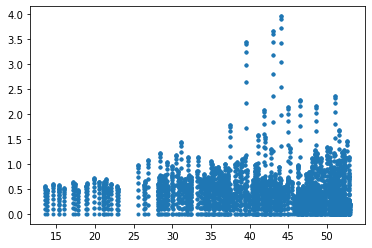

In [5]:
positive = df.loc[df['Points:1'] >= 0]
xPositive = positive['Points:0'].to_numpy()
yPositive = positive['Points:1'].to_numpy()
yMean = np.mean(yPositive)
print(len(xPositive), len(yPositive))

plt.plot(xPositive, yPositive, '.')

In [6]:
stdY = np.std(yPositive)
print(4*stdY, yMean+(2*stdY))

1.6630899098461285 1.2997440765400947


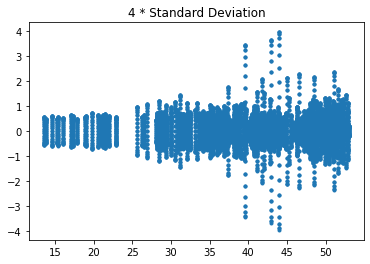

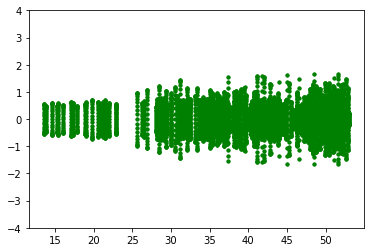

In [8]:
pX = []
pY = []

nX = []
nY = []

plt.figure()
plt.title('4 * Standard Deviation')
plt.plot(x,y, '.')
for i in range(0, len(yPositive)):
    if yPositive[i] <=  (4 * stdY) : 
        pX.append(xPositive[i])
        pY.append(yPositive[i])
        
        nX.append(xPositive[i])
        nY.append(-yPositive[i])
        
plt.figure()
plt.ylim([-4,4])
plt.plot(nX, nY, 'g.')
plt.plot(pX, pY, 'g.')

210.csv


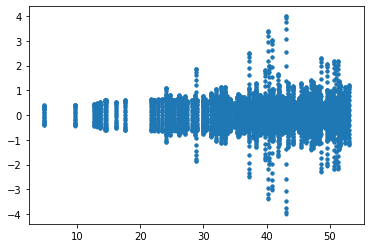

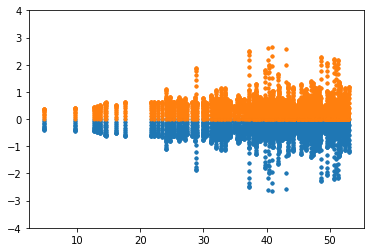

211.csv


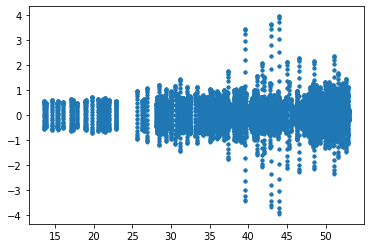

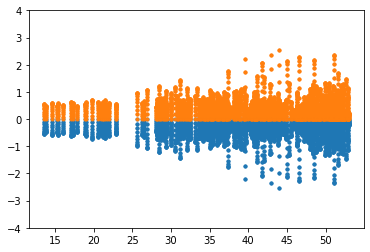

212.csv


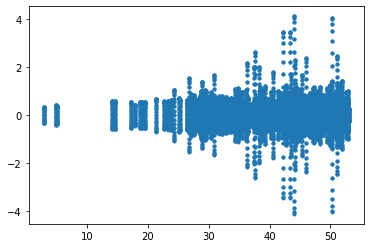

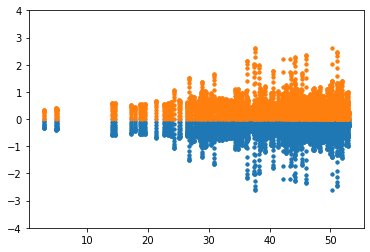

213.csv


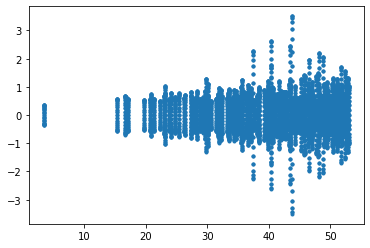

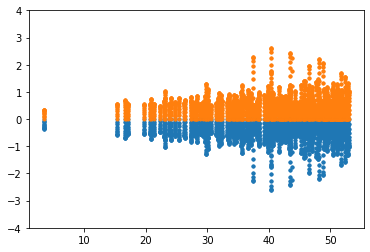

214.csv


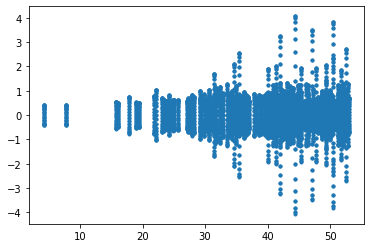

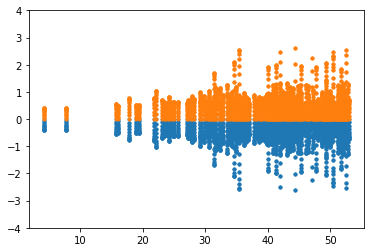

215.csv


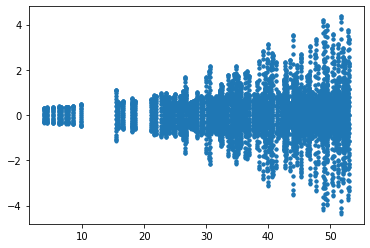

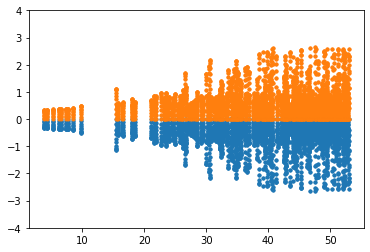

216.csv


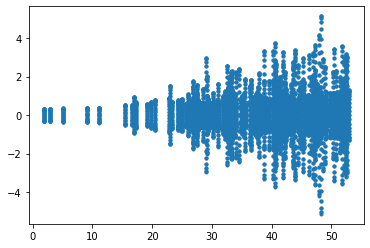

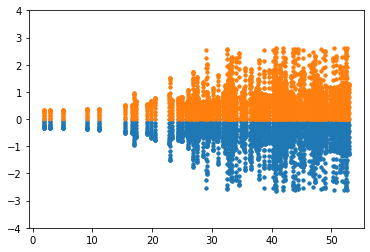

217.csv


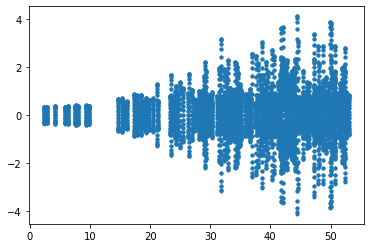

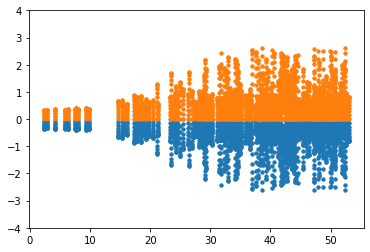

218.csv


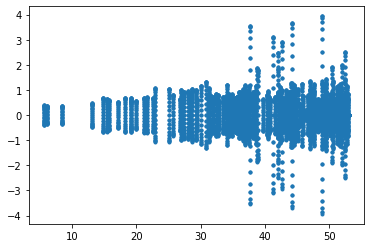

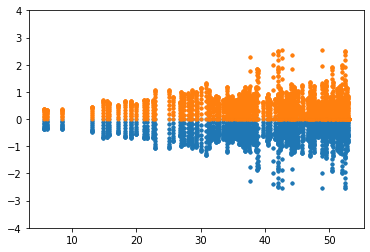

219.csv


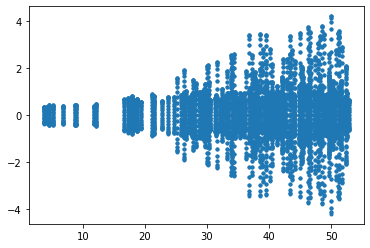

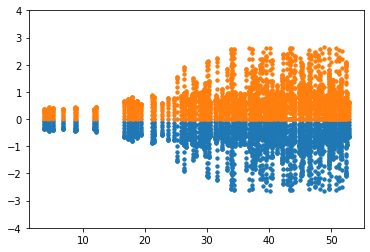

In [33]:
fileName = []
area = []
length = []
height = []
width = []
slope = []

alphaValue = 0.35
ordBounLen = 5
maximaDistance = 0.4

folders = ['newData']
# file = '217.csv'
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        print(file)
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()
        
        positive = df.loc[df['Points:1'] >= 0]
        xPositive = positive['Points:0'].to_numpy()
        yPositive = positive['Points:1'].to_numpy()
        yMean = np.mean(yPositive)
#         print(len(xPositive), len(yPositive))

        pX = []
        pY = []

        nX = []
        nY = []

        plt.figure()
        plt.plot(x,y, '.')
        plt.show()
        for i in range(0, len(yPositive)):
            if yPositive[i] <=  (4 * stdY) : 
                pX.append(xPositive[i])
                pY.append(yPositive[i])

                nX.append(xPositive[i])
                nY.append(-yPositive[i])

        plt.figure()
        plt.ylim([-4,4])
        plt.plot(nX, nY, '.')
        plt.plot(pX, pY, '.')
        plt.show()
        